In [1]:
### - Harris Corner Python Notebook - ###
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [18]:
#Given helper functions
def conv2(img, conv_filter):
    # flip the filter
    f_siz_1, f_size_2 = conv_filter.shape
    conv_filter = conv_filter[range(f_siz_1 - 1, -1, -1), :][:, range(f_siz_1 - 1, -1, -1)]
    pad = (conv_filter.shape[0] - 1) // 2
    result = np.zeros((img.shape))
    img = np.pad(img, ((pad, pad), (pad, pad)), 'constant', constant_values=(0, 0))
    filter_size = conv_filter.shape[0]
    for r in np.arange(img.shape[0] - filter_size + 1):
        for c in np.arange(img.shape[1] - filter_size + 1):
            curr_region = img[r:r + filter_size, c:c + filter_size]
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result)  # Summing the result of multiplication.
            result[r, c] = conv_sum  # Saving the summation in the convolution layer feature map.

    return result


def fspecial(shape=(3, 3), sigma=0.5):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]
    h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [32]:
# Parameters, add more if needed
#Globals:
path = "/Users/bigc/Documents/Comp/4528/CLab-2/Task1/"
curr_img = cv.cvtColor(cv.imread(path + "Harris-1.jpg"), cv.COLOR_BGR2GRAY) #Import greyscale

def harris_detect(img): #Inputs(Greyscale image)
    #Task 1 (a):
    sigma = 2
    thresh = 0.01
    e_const = 0.04

    # Derivative masks
    dx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    dy = dx.transpose()

    bw = img
    bw = np.array(bw * 255, dtype=int)
    # computer x and y derivatives of image
    Ix = conv2(bw, dx)
    Iy = conv2(bw, dy)

    g = fspecial((max(1, np.floor(3 * sigma) * 2 + 1), max(1, np.floor(3 * sigma) * 2 + 1)), sigma)
    Iy2 = conv2(np.power(Iy, 2), g)
    Ix2 = conv2(np.power(Ix, 2), g)
    Ixy = conv2(Ix * Iy, g)
    
    compares = 7 #Size of pixel comparisons for image grads.
    
    false_pad = int(np.floor(compares/2)) #Return integer value of radius.
    
    Cornerness = np.zeros(img.shape)
    
    for i in range(false_pad, img.shape[0]-(false_pad)): #Set values in R
        for j in range(false_pad, img.shape[1]-(false_pad)):
            #Find total sum of the intensity change 
            #x-intensity:
            X_intensity2 = Ix2[i-false_pad:i+false_pad, j-false_pad:j+false_pad].sum()
            Y_intensity2 = Iy2[i-false_pad:i+false_pad, j-false_pad:j+false_pad].sum()
            XY_Intensity = Ixy[i-false_pad:i+false_pad, j-false_pad:j+false_pad].sum()
            #Use these to determine the determinant and trace of our window
            harris_det = (X_intensity2 * Y_intensity2) - (XY_Intensity**2)
            
            harris_trace = X_intensity2+Y_intensity2 #Allows for fast computation of these values
            
            Cornerness[i][j] = harris_det-e_const*(harris_trace**2) #Set values of R according to the formula in class
    #We now have a matrix, that has Harris Cornerness of each pixel value
    thresh = thresh*np.max(Cornerness) #Find threshold to remove from Cornerness
    #Set all values less than thresh = 0
    for k in range(Cornerness.shape[0]):
        for l in range(Cornerness.shape[1]):
            if Cornerness[k][l] < thresh:
                Cornerness[k][l] = 0
    
    s_size = 15
    
    sm = Cornerness #Set the suppression matrix equal to the cornerness matrix
    
    suppression_fp = int(np.floor(s_size/2)) #Same logic as before for window sizing
    
    for x in range(suppression_fp, img.shape[0]-(suppression_fp+1)):
        for y in range(suppression_fp, img.shape[1]-(suppression_fp+1)):
            #Similar for loop structure except now we are gonna operate on the suppression matrix
            #retrieve window of our suppression matrix
            
            w_sm = sm[x-suppression_fp:x+suppression_fp, y-suppression_fp:y+suppression_fp]
            if not np.max(w_sm) == Cornerness[x][y]:
                sm[i][j] = 0
    plt.imshow(sm)
    return sm

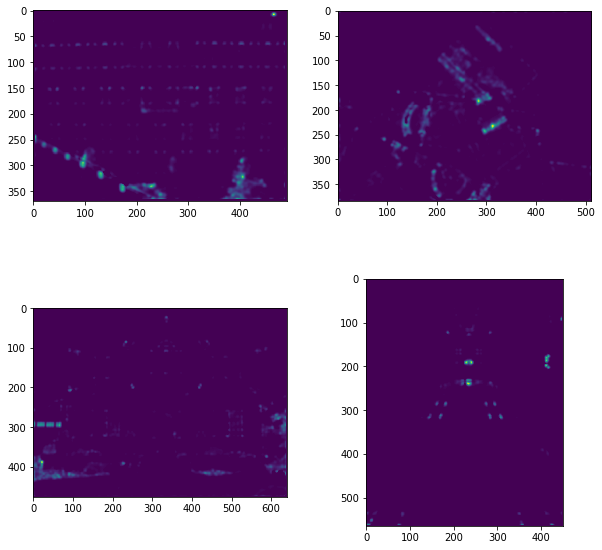

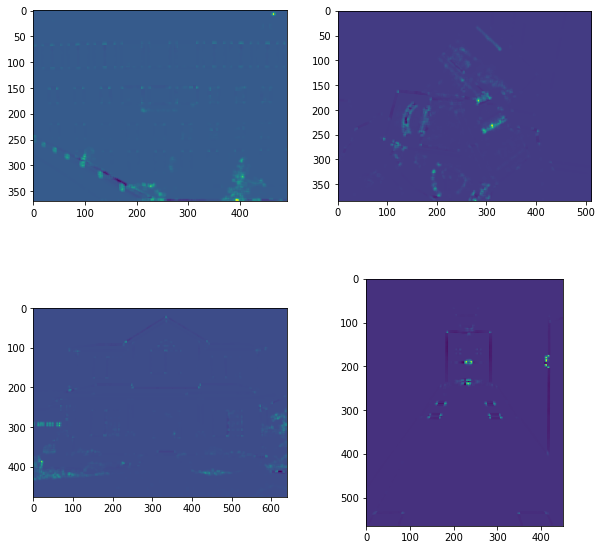

In [45]:
from matplotlib.gridspec import GridSpec
fig, ax = plt.subplots(2, 2, figsize=(10,10))
fig1, ax1 = plt.subplots(2, 2, figsize=(10,10))
gs = GridSpec(nrows=2, ncols=2)
for x in range(4):
    if x == 0:
        inside = (0,0)
    elif x == 1:
        inside = (0,1)
    elif x == 2:
        inside = (1,0)
    else:
        inside = (1,1)
    curr_img = cv.cvtColor(cv.imread(path + "Harris-" + str(x+1) + ".jpg"), cv.COLOR_BGR2GRAY) #Import greyscale
    mycorners = harris_detect(curr_img)
    cvcorners = cv.cornerHarris(curr_img, 7, 3, 0.04)
    ax1[inside[0], inside[1]].imshow(cvcorners)
    ax[inside[0], inside[1]].imshow(mycorners)
plt.show()